In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from openpyxl import Workbook

# Load data
diet_df = pd.read_csv("diet_recommendations_dataset.csv")
allergens_df = pd.read_csv("food_ingredients_and_allergens.csv")
nutrition_df = pd.read_excel("SHORT VERSION OF FOOD NUTRITUION.xlsx")

# Clean and preprocess diet data
def clean_diet_data(df):
    df = df.copy()
    df.fillna("None", inplace=True)
    df['Allergies'] = df['Allergies'].apply(lambda x: x.split(",") if x != "None" else [])
    return df

diet_df = clean_diet_data(diet_df)

# Features to extract
features = ['Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI', 'Disease_Type',
            'Physical_Activity_Level', 'Cholesterol_mg/dL', 'Blood_Pressure_mmHg', 'Glucose_mg/dL']

numeric_features = ['Age', 'Weight_kg', 'Height_cm', 'BMI', 'Cholesterol_mg/dL', 'Blood_Pressure_mmHg', 'Glucose_mg/dL']
categorical_features = ['Gender', 'Disease_Type', 'Physical_Activity_Level']

# Preprocessor for scaling and encoding
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])

# Dummy model prediction simulator
def dummy_predict_meals(food_df, k=28):
    return random.choices(food_df['product_name'].dropna().tolist(), k=k)

# Filter food based on health conditions
def filter_foods_by_conditions(food_df, patient, allergen_df):
    df = food_df.copy()

    if patient['Disease_Type'] == 'Diabetes':
        df = df[(df['sugars_100g'] <= 5) & (df['carbohydrates_100g'] <= 30)]

    if patient['Disease_Type'] == 'Obesity':
        df = df[df['fat_100g'] <= 10]

    for allergen in patient['Allergies']:
        if allergen.strip():
            allergen_foods = allergen_df[allergen_df['Allergens'].str.contains(allergen, case=False, na=False)]['Food Product']
            df = df[~df['product_name'].isin(allergen_foods)]

    return df

# Generate meal plan
def generate_meal_plan(patient_row, food_df, allergen_df):
    filtered_foods = filter_foods_by_conditions(food_df, patient_row, allergen_df)
    meals = dummy_predict_meals(filtered_foods, k=28)
    return [meals[i*4:(i+1)*4] for i in range(7)]

# Pick a sample patient and generate plan
sample_patient = diet_df.iloc[0]
meal_plan = generate_meal_plan(sample_patient, nutrition_df, allergens_df)

# Write to Excel
wb = Workbook()
ws = wb.active
ws.title = "Weekly Diet Plan"

# Header
ws.append(["Day", "Meal 1", "Meal 2", "Meal 3", "Meal 4"])

# Add data
for i, day in enumerate(meal_plan, 1):
    ws.append([f"Day {i}"] + day)

# Save file
wb.save("weekly_diet_plan.xlsx")
print("Meal plan saved to 'weekly_diet_plan.xlsx'")


Meal plan saved to 'weekly_diet_plan.xlsx'


In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from openpyxl import Workbook

# --- Load and Prepare Data ---
diet_df = pd.read_csv("diet_recommendations_dataset.csv")
allergens_df = pd.read_csv("food_ingredients_and_allergens.csv")
nutrition_df = pd.read_excel("SHORT VERSION OF FOOD NUTRITUION.xlsx")

def clean_diet_data(df):
    df = df.copy()
    df.fillna("None", inplace=True)
    df['Allergies'] = df['Allergies'].apply(lambda x: x.split(",") if x != "None" else [])
    return df

diet_df = clean_diet_data(diet_df)

# Features & Preprocessing
features = ['Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI', 'Disease_Type',
            'Physical_Activity_Level', 'Cholesterol_mg/dL', 'Blood_Pressure_mmHg', 'Glucose_mg/dL']
numeric_features = ['Age', 'Weight_kg', 'Height_cm', 'BMI', 'Cholesterol_mg/dL', 'Blood_Pressure_mmHg', 'Glucose_mg/dL']
categorical_features = ['Gender', 'Disease_Type', 'Physical_Activity_Level']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(), categorical_features)
])

X = diet_df[features]
X_processed = preprocessor.fit_transform(X)

y = pd.factorize(diet_df['Diet_Recommendation'])[0]
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_cat, test_size=0.2, random_state=42)

# --- Build Model ---
def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(y_cat.shape[1], activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# --- Classification Report ---
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

target_names = pd.factorize(diet_df['Diet_Recommendation'])[1]
report = classification_report(y_true_labels, y_pred_labels, target_names=target_names)
print(report)

# --- Meal Filtering Logic ---
def filter_foods_by_conditions(food_df, patient, allergen_df):
    df = food_df.copy()
    if patient['Disease_Type'] == 'Diabetes':
        df = df[(df['sugars_100g'] <= 5) & (df['carbohydrates_100g'] <= 30)]
    if patient['Disease_Type'] == 'Obesity':
        df = df[df['fat_100g'] <= 10]
    for allergen in patient['Allergies']:
        if allergen.strip():
            allergen_foods = allergen_df[allergen_df['Allergens'].str.contains(allergen, case=False, na=False)]['Food Product']
            df = df[~df['product_name'].isin(allergen_foods)]
    return df

# --- Meal Plan Generator for 30 Days ---
def generate_meal_plan(patient_row, food_df, allergen_df, days=30):
    filtered_foods = filter_foods_by_conditions(food_df, patient_row, allergen_df)
    meals = random.choices(filtered_foods['product_name'].dropna().tolist(), k=days * 4)
    return [meals[i*4:(i+1)*4] for i in range(days)]

# --- Generate Plan for 1 Patient ---
sample_patient = diet_df.iloc[0]
meal_plan_30 = generate_meal_plan(sample_patient, nutrition_df, allergens_df, days=30)

# --- Write 30-Day Plan to Excel ---
wb = Workbook()
ws = wb.active
ws.title = "30-Day Meal Plan"
ws.append(["Day", "Meal 1", "Meal 2", "Meal 3", "Meal 4"])

for i, day_meals in enumerate(meal_plan_30, start=1):
    ws.append([f"Day {i}"] + day_meals)

wb.save("30_day_meal_plan.xlsx")
print("30-day meal plan saved to '30_day_meal_plan.xlsx'")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3936 - loss: 1.0700 - val_accuracy: 0.4750 - val_loss: 0.9076
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5973 - loss: 0.8524 - val_accuracy: 0.9625 - val_loss: 0.6622
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8733 - loss: 0.5942 - val_accuracy: 1.0000 - val_loss: 0.3271
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9757 - loss: 0.3044 - val_accuracy: 1.0000 - val_loss: 0.1075
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9899 - loss: 0.1349 - val_accuracy: 1.0000 - val_loss: 0.0313
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0334 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9975 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 0.0041
Ep

In [3]:
pip install tensorflow pandas openpyxl scikit-learn

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,091 (98.01 KB)

 Trainable params: 25,091 (98.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4663 - loss: 1.0782 - val_accuracy: 0.5250 - val_loss: 1.0242
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6189 - loss: 0.9799 - val_accuracy: 0.6125 - val_loss: 0.9033
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7487 - loss: 0.8123 - val_accuracy: 0.9250 - val_loss: 0.6429
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.5249 - val_accuracy: 1.0000 - val_loss: 0.2941
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.2157 - val_accuracy: 1.0000 - val_loss: 0.0873
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0652 - val_accuracy: 1.0000 - val_loss: 0.0318
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0246 - val_accuracy: 1.0000 - val_loss: 0.0169
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss

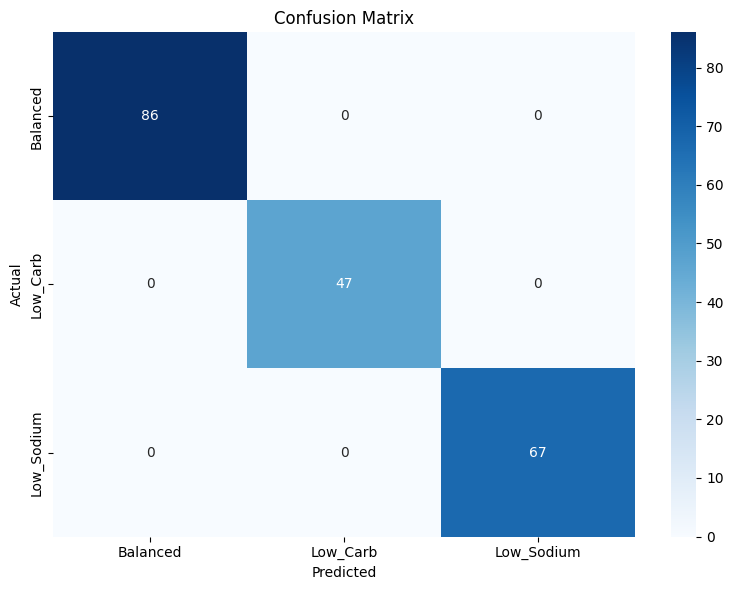


Enter your health details below. Follow these instructions:
- Gender: Enter either 'Male' or 'Female'.
- Disease_Type: You can enter multiple conditions separated by commas (e.g., Diabetes,Obesity).
- Allergies: Type ingredients separated by commas (e.g., peanuts,shellfish). Leave empty if none.


Example Input:
{'Age': 35, 'Gender': 'Male', 'Weight_kg': 78, 'Height_cm': 172, 'BMI': 26.3, 'Disease_Type': 'Diabetes,Obesity', 'Physical_Activity_Level': 'Low', 'Cholesterol_mg/dL': 210, 'Blood_Pressure_mmHg': 130, 'Glucose_mg/dL': 150, 'Allergies': 'peanuts,milk'}
Age:  35
Gender (Male/Female): Male
Weight (kg): 78
Height (cm): 172
BMI: 26.3
Disease(s) (None/Diabetes/Obesity or comma-separated): Diabetes,Obesity
Activity Level (Low/Medium/High): Low
Cholesterol: 210
Blood Pressure: 130
Glucose: 150
Allergies (comma separated, leave empty if none): peanuts
Repeat Diseases for filtering (same as above): Diabetes,Obesity
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Recommended Diet Type: Low_Carb


In [8]:
import pandas as pd
import numpy as np
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from openpyxl import Workbook
import matplotlib.pyplot as plt
import seaborn as sns


diet_df = pd.read_csv("diet_recommendations_dataset.csv")
allergens_df = pd.read_csv("food_ingredients_and_allergens.csv")
nutrition_df = pd.read_excel("FOOD NUTRITION DATASET.xlsx")

def clean_diet_data(df):
    df = df.copy()
    df.fillna("None", inplace=True)
    df['Allergies'] = df['Allergies'].apply(lambda x: x.split(",") if x != "None" else [])
    df['Disease_Type'] = df['Disease_Type'].apply(lambda x: x.split(",")[0] if "," in x else x)
    return df

diet_df = clean_diet_data(diet_df)

features = ['Age', 'Gender', 'Weight_kg', 'Height_cm', 'BMI', 'Disease_Type',
            'Physical_Activity_Level', 'Cholesterol_mg/dL', 'Blood_Pressure_mmHg', 'Glucose_mg/dL']
numeric_features = ['Age', 'Weight_kg', 'Height_cm', 'BMI', 'Cholesterol_mg/dL', 'Blood_Pressure_mmHg', 'Glucose_mg/dL']
categorical_features = ['Gender', 'Disease_Type', 'Physical_Activity_Level']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X = diet_df[features]
X_processed = preprocessor.fit_transform(X)

y, labels = pd.factorize(diet_df['Diet_Recommendation'])
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_cat, test_size=0.2, random_state=42)

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

input_seq = Input(shape=(1, X_train.shape[1]))
x = LSTM(64, return_sequences=False)(input_seq)
x = Dense(64, activation='relu')(x)
output = Dense(y_cat.shape[1], activation='softmax')(x)

model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train_lstm, y_train, epochs=15, batch_size=32, validation_split=0.1)


y_pred = model.predict(X_test_lstm)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


def get_user_input():
    print("""
Enter your health details below. Follow these instructions:
- Gender: Enter either 'Male' or 'Female'.
- Disease_Type: You can enter multiple conditions separated by commas (e.g., Diabetes,Obesity).
- Allergies: Type ingredients separated by commas (e.g., peanuts,shellfish). Leave empty if none.
""")
    print("\nExample Input:")
    print({
        'Age': 35,
        'Gender': 'Male',
        'Weight_kg': 78,
        'Height_cm': 172,
        'BMI': 26.3,
        'Disease_Type': 'Diabetes,Obesity',
        'Physical_Activity_Level': 'Low',
        'Cholesterol_mg/dL': 210,
        'Blood_Pressure_mmHg': 130,
        'Glucose_mg/dL': 150,
        'Allergies': 'peanuts,milk'
    })

    user_data = {
        'Age': float(input("Age: ")),
        'Gender': input("Gender (Male/Female): "),
        'Weight_kg': float(input("Weight (kg): ")),
        'Height_cm': float(input("Height (cm): ")),
        'BMI': float(input("BMI: ")),
        'Disease_Type': input("Disease(s) (None/Diabetes/Obesity or comma-separated): ").split(",")[0],
        'Physical_Activity_Level': input("Activity Level (Low/Medium/High): "),
        'Cholesterol_mg/dL': float(input("Cholesterol: ")),
        'Blood_Pressure_mmHg': float(input("Blood Pressure: ")),
        'Glucose_mg/dL': float(input("Glucose: ")),
        'Allergies': input("Allergies (comma separated, leave empty if none): ").split(",")
    }
    user_data['Raw_Diseases'] = input("Repeat Diseases for filtering (same as above): ").lower()
    return user_data

def filter_foods(food_df, patient, allergen_df):
    df = food_df.copy()
    diseases = [d.strip().lower() for d in patient['Raw_Diseases'].split(",")]

    if 'diabetes' in diseases:
        df = df[(df['sugars_100g'] <= 5) & (df['carbohydrates_100g'] <= 30)]
    if 'obesity' in diseases:
        df = df[df['fat_100g'] <= 10]

    for allergen in patient['Allergies']:
        if allergen.strip():
            allergen_foods = allergen_df[allergen_df['Allergens'].str.contains(allergen, case=False, na=False)]['Food Product']
            df = df[~df['product_name'].isin(allergen_foods)]
    return df


def generate_meal_plan(patient_row, food_df, allergen_df, days=7):
    filtered_foods = filter_foods(food_df, patient_row, allergen_df)
    meals = random.choices(filtered_foods['product_name'].dropna().tolist(), k=days * 4)
    return [meals[i*4:(i+1)*4] for i in range(days)]


user_patient = get_user_input()
X_user_df = pd.DataFrame([user_patient])[features]
X_user_proc = preprocessor.transform(X_user_df)
X_user_seq = np.reshape(X_user_proc, (1, 1, X_user_proc.shape[1]))

predicted_class = model.predict(X_user_seq)
diet_type = labels[np.argmax(predicted_class)]
print(f"\nRecommended Diet Type: {diet_type}")


meal_plan = generate_meal_plan(user_patient, nutrition_df, allergens_df, days=7)

wb = Workbook()
ws = wb.active
ws.title = "7-Day Diet Plan"
ws.append(["Day", "Meal 1", "Meal 2", "Meal 3", "Meal 4"])
for i, meals in enumerate(meal_plan, start=1):
    ws.append([f"Day {i}"] + meals)

wb.save("7_day_meal_plan_lstm.xlsx")
print("\n✅ 7-day personalized diet plan saved as '7_day_meal_plan_lstm.xlsx'")